In [1]:
# Data loading
import json
import gzip

# Data processing
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import time
import datetime

# Data vizualizations
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Data modeling
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
###################################### LOAD DATA #############################################################
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
# l.strip() to prevent the load of empty line
# get into pandas dataframe for better data handling
input_file = '../Data/reviews_Cell_Phones_and_Accessories_5.json.gz'
data = []
with gzip.open(input_file) as f:
    for l in f:
        data.append(json.loads(l.strip()))

df = pd.DataFrame.from_dict(data)
df = df[['reviewText', 'overall']]

print("Amount of reviews: ", len(data))

print(df.loc[0])

Amount of reviews:  194439
reviewText    They look good and stick good! I just don't li...
overall                                                       4
Name: 0, dtype: object


In [3]:
############################# DUPLICATE DETECTION & DELETION ##################################################
print('Before deleting duplicate entries: ', len(df))
df = df.drop_duplicates()
print('After deleting duplicate entries: ', len(df))
dup = df[df['reviewText'].isin(df['reviewText'][df['reviewText'].duplicated()])]
# print(len(dup))
# print(dup[5:50])
df = df.drop_duplicates(subset=['reviewText'])
print('After deleting duplicate review texts: ', len(df))

# Sample survey
# dup[(dup['reviewText'].str.contains("love") | dup['reviewText'].str.contains("Love") | dup['reviewText'].str.contains("LOVE"))]
# dup[(dup['reviewText'].str.contains("good") | dup['reviewText'].str.contains("Good"))]
# dup[(dup['reviewText'].str.contains("great") | dup['reviewText'].str.contains("Great"))]
# dup[(dup['reviewText'].str.contains("ok") | dup['reviewText'].str.contains("OK"))]
# dup[(dup['reviewText'].str.contains("nice") | dup['reviewText'].str.contains("Nice"))]
# dup[(dup['reviewText'].str.contains("perfect") | dup['reviewText'].str.contains("Perfect"))]

Before deleting duplicate entries:  194439
After deleting duplicate entries:  194226
After deleting duplicate review texts:  194186


In [4]:
################################## EMPTY REVIEWS DELETION ######################################################
print('Before deleting empty review texts: ', len(df))
df = df[df['reviewText'] != '']
print('After deleting empty review texts: ', len(df))
# df[df['reviewText'].str.contains("null")]

Before deleting empty review texts:  194186
After deleting empty review texts:  194185


In [5]:
#################################### WORD COUNT ################################################################
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))

In [ ]:
longest_t = df[df['word_count'] == max(df['word_count'])]
print('The longest review text in our sample has {} words.'.format(max(df['word_count'])))
print('Longest review text:' + '\n')
print(longest_t.reviewText)

shortest_t = df[df['word_count'] == min(df['word_count'])]
print('The shortest review text in our sample has {} words.'.format(min(df['word_count'])))
print('Review text with the shortest length of {} word appearing {} times.'.format(min(df['word_count']), len(shortest_t)))

plt.rcParams['figure.facecolor'] = 'white'
plt.hist(df['word_count'].value_counts().sort_index(), range=(0,6000), bins=100, log=True)
plt.xlabel('Text length')
plt.ylabel('Distribution')
plt.title('Text lengths in words (Amazon Movie&TV)')
plt.savefig('../Figures/amazon_cell_textlength_raw_logarithmic.png')
df['word_count'].describe()

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.hist(df['word_count'].value_counts().sort_index(), range=(0,6000), bins=100)
plt.xlabel('Text length')
plt.ylabel('Distribution')
plt.title('Text lengths in words (Amazon Movie&TV)')
plt.savefig('../Figures/amazon_cell_textlength_raw.png')

In [ ]:
################################## RATING DISTRIBUTION ###########################################

print(df['overall'].value_counts())
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Class')
plt.ylabel('Amount')
plt.hist(df['overall'], bins=np.arange(0.5, 6), rwidth=0.5)
plt.savefig('../Figures/amazon_cell_class_dist_raw.png')

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

dPlot = []
categories = [1.0, 2.0, 3.0, 4.0, 5.0]
for i in range(5):
    trace = go.Box(
        y = df[(df['overall'] == categories[i])]['word_count'],
        name = categories[i]
    )
    dPlot.append(trace)

layout = go.Layout(
    height = 1000,
    width = 1200,
    title = "Review Text - Length Distribution by Label",
    margin = dict(l = 30, r = 20, b = 150, t = 90)
)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

fig = go.Figure(data=dPlot, layout=layout)
iplot(fig, filename = "amazon_cell_textlength_per_class_raw")

In [ ]:
# Konservieren von Datareview nicht weniger als 4 Wörter
more4cellphoneama_df = df[(df['word_count']>4)]
more4cellphoneama_df.to_pickle("./more4cellama.pkl")

In [6]:
# Lowercasing
from Scripts import preprocessing as prep
df['reviewText'] = [prep.to_lowercase(line) for line in df['reviewText']]

In [7]:
# reviews = [prep.remove_punct_and_nonascii(line) for line in reviews] funktioniert vielleicht nicht ganz, nächste Zeile dafür schon
df['reviewText'] = df['reviewText'].str.replace('[^a-zA-Z0-9]',' ')

In [24]:
df['reviewText'][100]

'luving it right now will last about 4 mo so you cant beat the price for it i got 4 of them'

In [ ]:
df.loc[10]['overall']

In [8]:
# Remove numerical values
df['numerics'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()])) # counting numericals

In [23]:
df.numerics[100]

2

In [25]:
sum(df.numerics) #259468

259468

In [28]:
print('Numerics as percentage of all words in the corpus: {:.2%} '.format(sum(df.numerics)/sum(df.word_count)))

Numerics as percentage of all words in the corpus: 1.21% 


In [31]:
pattern = re.compile(r'([a-zA-Z]*[0-9])|(\S*[0-9]\S)|([0-9])')
df['numerics_mix'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if pattern.findall(x)]))

In [33]:
# df.numerics_mix[10]
print('Numerics as percentage of all words in the corpus: {:.2%} '.format(sum(df.numerics_mix)/sum(df.word_count)))

Numerics as percentage of all words in the corpus: 1.66% 


In [9]:
df['reviewText'] = [prep.remove_numbers(line) for line in df['reviewText']]

In [10]:
# stop words
stop = stopwords.words ('english')
stop = [e for e in stop if e not in ('but', 'no', 'not')]

In [38]:
print('The list of stop words consists of {} words.'.format(len(stop)))

The list of stop words consists of 179 words.


In [16]:
df['stopwords'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [41]:
print('The number of stop words in development sample: {}'.format(sum(df.stopwords)))

The number of stop words in development sample: 9439110


In [ ]:
print('Stop words as percentage of all words in the corpus: {:.2%} '.format(sum(df.stopwords)/sum(df.word_count)))

In [12]:
# Remove the stop words
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [15]:
### here include PorterStemming
df['reviewText'] = [prep.stem(line) for line in df['reviewText']]

In [44]:
# Find most common words
corpus = pd.Series(' '.join(df['reviewText']).split())

In [45]:
# Separately for industry categories
corpus_1 = pd.Series(' '.join(df[df['overall'] == 1.0]['reviewText']).split())
corpus_2 = pd.Series(' '.join(df[df['overall'] == 2.0]['reviewText']).split())
corpus_3 = pd.Series(' '.join(df[df['overall'] == 3.0]['reviewText']).split())
corpus_4 = pd.Series(' '.join(df[df['overall'] == 4.0]['reviewText']).split())
corpus_5 = pd.Series(' '.join(df[df['overall'] == 5.0]['reviewText']).split())

In [47]:
print(len(corpus.unique())) #75030
print(len(corpus_1.unique())) #17881
print(len(corpus_2.unique())) #18153
print(len(corpus_3.unique())) #24682
print(len(corpus_4.unique()) )#35431
print(len(corpus_5.unique())) #52175

75030
17881
18153
24682
35431
52175


In [57]:
corpus_counts = Counter(corpus)
corpus_counts_1 = Counter(corpus_1)
corpus_counts_2 = Counter(corpus_2)
corpus_counts_3 = Counter(corpus_3)
corpus_counts_4 = Counter(corpus_4)
corpus_counts_5 = Counter(corpus_5)


In [52]:
mostcommon = pd.DataFrame(corpus_counts.most_common(100),  columns=['Word', 'Frequency'])
mostcommon[0:50]


,Word,Frequency
0,phone,181721
1,case,150018
2,one,89944
3,like,74065
4,great,68848
5,use,63213
6,screen,62368
7,good,60324
8,battery,59364
9,would,55733


In [58]:
mostcommon_1= pd.DataFrame(corpus_counts_1.most_common(100),  columns=['Word', 'Frequency'])
mostcommon_2= pd.DataFrame(corpus_counts_2.most_common(100),  columns=['Word', 'Frequency'])
mostcommon_3= pd.DataFrame(corpus_counts_3.most_common(100),  columns=['Word', 'Frequency'])
mostcommon_4= pd.DataFrame(corpus_counts_4.most_common(100),  columns=['Word', 'Frequency'])
mostcommon_5= pd.DataFrame(corpus_counts_5.most_common(100),  columns=['Word', 'Frequency'])

mostcommon_1[0:20]
mostcommon_2[0:20]
mostcommon_3[0:20]
mostcommon_4[0:20]
mostcommon_5[0:20]

In [64]:
mostrare = {x : corpus_counts[x] for x in corpus_counts if corpus_counts[x] == 1 } # a dictionary comprehension
len(mostrare)
mostrare

39639

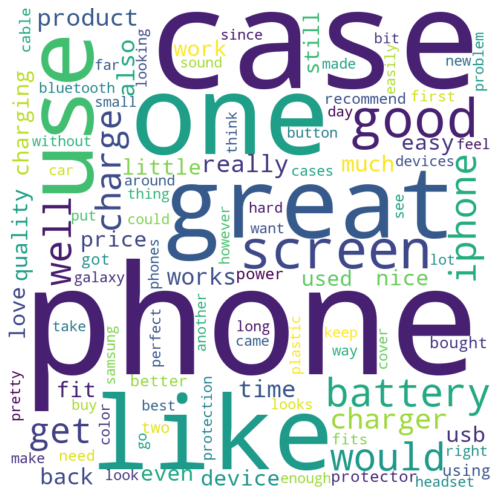

In [68]:
mostcommon = mostcommon.set_index('Word').to_dict()['Frequency'] # dictionary
wordcloud = WordCloud(max_words = 100, width=800, height=800, background_color='white', random_state = 42).generate_from_frequencies(mostcommon)
plt.figure(figsize=(8,8), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [25]:
# Split the dataset
df = df.loc[:,['reviewText', 'overall']]

In [26]:
train, test = train_test_split(df, train_size = 0.80, random_state=123, stratify = df.overall)

In [27]:
train, valid = train_test_split(train, train_size = 0.75, random_state=123, stratify = train.overall)

In [28]:
test.info() # 58256 entries, 22157 - 8218

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38837 entries, 108343 to 173955
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  38837 non-null  object 
 1   overall     38837 non-null  float64
dtypes: float64(1), object(1)
memory usage: 910.2+ KB


In [29]:
train.info() # 135929 entries, 31582 to 71874

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116511 entries, 82205 to 37707
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  116511 non-null  object 
 1   overall     116511 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.7+ MB


In [30]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38837 entries, 114611 to 40097
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  38837 non-null  object 
 1   overall     38837 non-null  float64
dtypes: float64(1), object(1)
memory usage: 910.2+ KB


In [33]:
trace = go.Table(header=dict(values=['Sentiment', 'Number of reviews', 'As Percentage'],
                             fill = dict(color=['#da80ec']),
                             align = ['left'] * 5),
                 cells=dict(values=[train.overall.value_counts().keys(),
                                    train.overall.value_counts(),['{:.2%}'.format(x) for x in train.overall.value_counts()/len(train)]],
                            align = ['left'] * 5))

layout = go.Layout(title='Target distribution in the train sample',
                   titlefont = dict(size = 20),
                   width=800, height=400,
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = True,
                   yaxis=go.layout.YAxis(automargin = True),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)


In [86]:
trace = go.Table(header=dict(values=['Sentiment', 'Number of reviews', 'As Percentage'],
                             fill = dict(color=['#da80ec']),
                             align = ['left'] * 5),
                 cells=dict(values=[test.overall.value_counts().keys(),
                                    test.overall.value_counts(),['{:.2%}'.format(x) for x in test.overall.value_counts()/len(test)]],
                            align = ['left'] * 5))

layout = go.Layout(title='Target distribution in the train sample',
                   titlefont = dict(size = 20),
                   width=800, height=900,
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = True,
                   yaxis=go.layout.YAxis(automargin = True),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
# del mostcommon
# del mostrare
# del corpus
# del corpus_counts


In [101]:
# change to without 5000 as limitation
vectorizer = CountVectorizer(ngram_range = (1,3),# any word appearing in more than 90% of the sample will be discarded
                              # if we want features to be binary (the default is counts)
                             )

In [102]:
X_train = vectorizer.fit_transform(train.reviewText)

In [103]:
features = vectorizer.get_feature_names()
print('Extracted features (in alphabetical order)')
# print(features)
len(features)


Extracted features (in alphabetical order)


5189783

In [ ]:
# FEATURE SELECTION
start = time.time()

categories = [1.0, 2.0, 3.0, 4.0, 5.0]

FS_results = []
vocabulary = []
for cat in categories:
    mi = mutual_info_classif(X_train, train.overall == cat, discrete_features=True, random_state = 123)
    indices = np.argsort(mi) # get the indices of features
    feature_names = np.array(vectorizer.get_feature_names())[indices] # get the features' names
    values = mi[indices]
    # Create a dataframe with the most important 20 features in each class
    df = pd.DataFrame(list(reversed(feature_names))[:2000], columns = ['feature'])
    df['MI value'] = list(reversed(values))[:2000]
    df['Label'] = cat
    FS_results.append(df)
    vocabulary.append(list(reversed(feature_names))[:2000]) # save all the features in a separate list

end = time.time()
execution_time = end - start
print(datetime.timedelta(seconds=execution_time)) # ~ 0:49:47.837228

In [ ]:
FS_results

In [ ]:
# change 0,1,2,3,4
trace = go.Table(header=dict(values=['Word', 'MI Value', 'Category'],
                             fill = dict(color=['#55a0d4']),
                             align = ['left'] * 5),
                 cells=dict(values=[FS_results[0].feature.head(10), FS_results[0]['MI value'].head(10), FS_results[0].Label.head(10)],
                            align = ['left'] * 5))

layout = go.Layout(title='Feature importance by label',
                   titlefont = dict(size = 20),
                   width=500, height=500,
                   paper_bgcolor =  'white',
                   plot_bgcolor = 'rgba(0,0,0,0)'
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

# Some findings about the most important features
# Generally speaking, feature selection procedure managed to pick up terms that seem to be relevant to the respective categories
# a lot of overlapping features -> loss of discriminative power
# same stem (star, stars)
# Generally speaking, our feature selection procedure managed to pick up terms that definitely seem relevant to the respective categories.
# In almost all of the target classes we can find more specialized (associated directly with the category) terms. However, in a few of the categories we find mainly broad terms – ‘Marketing’, ‘Conglomerate_(company)’ and ‘Commercial_and_professional_ services’.
# There are a lot of terms having the same root (manufacture-manufacturer-manufacturing) or terms appearing in both singular and plural form (school-schools). However, in most of these cases the terms have roughly the same meaning, so having them presented in so many different forms may add unnecessary noise in data. In such cases, stemming and lemmatization techniques may be applied in order to normalize the data.
# There are certain broad terms that appear in most of the target classes – ex. ‘company’, ’services’, ’firm’, ‘products’. This may lead to loss of discriminative power.
# The word ‘manufacture’ or its derivatives appears to be one of the most important terms in several categories – ‘Manufacturing’, ‘Aerospace_and_defense’, ‘Chemical_industry’, ‘Engineering’, ‘Metal’ and ‘Automotive’. Its appearance in the mentioned categories makes sense but will probably lead to loss of discriminative power and high number of misclassifications between these categories.

In [ ]:
# flatten / combining all the features
vocabulary_set = []
for featureset in vocabulary:
    for term in featureset:
        vocabulary_set.append(term)

In [ ]:
vocabulary_set = list(sorted(set(vocabulary_set)))

In [ ]:
vocabulary_set

In [ ]:
len(vocabulary_set) #59



In [46]:
# modelling - features

vectorizer = CountVectorizer(binary= True, vocabulary=vocabulary_set)
X_train = vectorizer.fit_transform(train.reviewText)


In [47]:
len(vectorizer.get_feature_names())

1345

In [48]:
count_vect_df = pd.DataFrame(X_train.todense(), columns=vectorizer.get_feature_names())

In [49]:
count_vect_df.head()

,abl,abl charg,absolut,absolut love,access,accident,activ,actual,ad,ad bonu,...,would not purchas,would not recommend,would not stay,would prefer,would probabl,would recommend,would recommend anyon,would star,yet,zero star
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
train.reviewText.iloc[0]

'would give star cover back comput speak part cover screen open comput great protect second one first took lot abus kept comput damag free'

In [51]:
count_vect_df.iloc[0]

abl                      0
abl charg                0
absolut                  0
absolut love             0
access                   0
                        ..
would recommend          0
would recommend anyon    0
would star               0
yet                      0
zero star                0
Name: 0, Length: 1345, dtype: int64

In [52]:
y_train = train.overall

In [ ]:
# APPLY A MACHINE LEARNING ALGORITHM
# svm good because robust to outliers and its decision depend on support vectors
# observation that are far awa from the hyperplane but still on the correct side of the margin will not effect the classifiers decision
# difference between SVC and SVM

In [72]:
clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, tol=0.0001, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight='balanced', verbose=0, random_state=123, max_iter=1000)

In [73]:
clf.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual=False, random_state=123)

In [74]:
print('Mean accuracy of train sample:')
clf.score(X_train,y_train)

Mean accuracy of train sample:


0.6268592665070251

In [75]:
clf.score(X_train, y_train)

0.6268592665070251

In [76]:
# Validation
# Inspect the classification report on training sample
predictions_ontrain = clf.predict(X_train)

In [77]:
predictions_ontrain

array([4., 5., 5., ..., 4., 3., 5.])

In [144]:
y_train

99382     5.0
175672    5.0
171087    5.0
142837    2.0
81273     5.0
         ... 
36780     5.0
118852    1.0
167178    5.0
89954     5.0
159174    5.0
Name: overall, Length: 135929, dtype: float64

In [78]:
metrics.accuracy_score(y_train, predictions_ontrain) # 0.9108350038225609

0.6268592665070251

In [79]:
print(metrics.classification_report(y_train, predictions_ontrain,
                                    categories))

c:\users\d064966\appdata\local\continuum\anaconda3\envs\masterthesis\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning:

Pass labels=[1.0, 2.0, 3.0, 4.0, 5.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error



              precision    recall  f1-score   support

         1.0       0.43      0.71      0.53      7961
         2.0       0.26      0.25      0.25      6635
         3.0       0.36      0.36      0.36     12857
         4.0       0.49      0.30      0.37     23970
         5.0       0.78      0.83      0.80     65088

    accuracy                           0.63    116511
   macro avg       0.46      0.49      0.46    116511
weighted avg       0.62      0.63      0.61    116511



In [60]:
conf_mat = confusion_matrix(y_train, predictions_ontrain, labels = categories)

In [149]:
conf_mat

array([[ 2556,    19,   303,   398,  6011],
       [ 1016,    30,   524,   679,  5492],
       [  618,    26,  1525,  1864, 10967],
       [  358,    22,   756,  4094, 22735],
       [  522,    25,   531,  2424, 72434]], dtype=int64)

In [ ]:
colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
font_colors = ['#efecee', '#3c3636']
fig = ff.create_annotated_heatmap(z = conf_mat, x= categories, y = categories, colorscale= colorscale,
                                  font_colors=font_colors, showscale = True )
#Layout
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 12

fig['layout'].update(
    title='Confusion matrix - train sample',
    width=800,
    height=700,
    xaxis=dict(title='Predicted', titlefont = dict(size = 20), side = 'bottom'),
    yaxis=dict(title='Actual', titlefont = dict(size = 20)),
    autosize=False, margin=dict(l=220,r=30,b=220,t=50,pad=1))

iplot(fig, filename='annotated_heatmap_numpy')

In [80]:
# Validate on test sample
test_X = vectorizer.transform(test.reviewText)

In [81]:
predicted = clf.predict(test_X)

In [160]:
predicted

array([5., 5., 4., ..., 5., 3., 5.])

In [82]:
metrics.accuracy_score(test.overall, predicted)

0.6144140896567706

In [91]:
metrics.f1_score(test.overall, predicted, average='macro')

0.4390925159190095

In [93]:
metrics.precision_score(test.overall, predicted, average='macro')

0.4379368730053037

In [83]:
print(metrics.classification_report(test.overall, predicted,
                                    categories))

              precision    recall  f1-score   support

         1.0       0.41      0.69      0.51      2653
         2.0       0.21      0.20      0.20      2212
         3.0       0.33      0.33      0.33      4286
         4.0       0.47      0.28      0.35      7990
         5.0       0.77      0.83      0.80     21696

    accuracy                           0.61     38837
   macro avg       0.44      0.46      0.44     38837
weighted avg       0.60      0.61      0.60     38837



In [84]:
conf_mat = confusion_matrix(test.overall, predicted, labels = categories)


In [85]:
conf_mat

array([[ 1825,   290,   184,    72,   282],
       [  810,   438,   469,   160,   335],
       [  662,   532,  1403,   720,   969],
       [  404,   405,  1224,  2249,  3708],
       [  769,   443,   951,  1586, 17947]], dtype=int64)

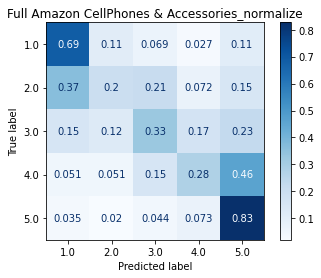

In [86]:
title = "Full Amazon CellPhones & Accessories"
title_norm = title + "_normalize"
disp_norm = plot_confusion_matrix(clf, test_X, test.overall,
                             display_labels=[1.0, 2.0, 3.0, 4.0, 5.0],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp_norm.ax_.set_title(title_norm)
plt.show()

In [ ]:
# Extract false negative
test['predicted'] = predicted

In [66]:
test.head()

,reviewText,overall,predicted
108343,good deal great product wish abl put phone hol...,4.0,5.0
41459,devic greatest strength simplic motorola right...,4.0,3.0
124072,sturdi case penni great case snap togeth great...,5.0,5.0
36540,like look but put screen saver creat bubbl scr...,3.0,5.0
31889,thought otterbox break but sure enough color r...,2.0,5.0


In [67]:
# Education category
print("'4.0' category is incorrectly classified as '5.0':" + '\n')
test[(test.overall== 4.0) & (test.predicted==5.0)].head(10)

'4.0' category is incorrectly classified as '5.0':



,reviewText,overall,predicted
108343,good deal great product wish abl put phone hol...,4.0,5.0
185319,great product plug usb comput thing work great...,4.0,5.0
68654,case great fit phone hole exact cut one wider ...,4.0,5.0
2975,realli enjoy new kill watt monitor first time ...,4.0,5.0
56152,kinivo three month blast use user friendli eas...,4.0,5.0
52405,bought month back price right work great abl c...,4.0,5.0
22182,actual screen protector great provid good cove...,4.0,5.0
186580,price good bought teal color happi case fit sn...,4.0,5.0
42860,like product didnt unstick easili main worri w...,4.0,5.0
9416,arriv quickli product easi use thing automat s...,4.0,5.0


In [ ]:
# Extract false negative

